In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from itables import init_notebook_mode, show
import mapclassify
import imageio.v2
import contextily as ctx
import os
#import random
# nit_notebook_mode( all_interactive = False)
plt.style.use('seaborn-v0_8-darkgrid')

In [2]:
filename = 'attentati.parquet'
path = os.path.abspath(os.path.join(os.pardir, "data","parquet"))
tr = pd.read_parquet(os.path.join(path, filename))
#tr.info(verbose=True)

In [3]:
#show(tr)

In [4]:
tr.tail(3)

,year,month,day,extended,resolution,country_number,country_name,region_number,region_name,provstate,...,ransomamtus,ransompaid,ransompaidus,ransomnote,hostkidoutcome,nreleased,addnotes,scite1,scite2,scite3
208354,2020,10,29,0,NaT,69,France,8,Western Europe,None,...,NaN,NaN,NaN,None,NaN,NaN,There is doubt that this incident meets terror...,"""Man shot dead by French police in Avigon belo...","""Second France ‘terrorist attack’: Knife-wield...","""Police Kill Armed Man Who Threatened Public i..."
208357,2020,10,29,0,NaT,69,France,8,Western Europe,None,...,NaN,NaN,NaN,None,NaN,NaN,There is doubt that this incident meets terror...,"""Man shot dead by French police in Avigon belo...","""Terrorism Digest: 30-31 Oct 20,"" BBC Monitori...",None
208396,2020,10,31,0,NaT,69,France,8,Western Europe,None,...,NaN,NaN,NaN,None,NaN,NaN,None,"""Arson attack targets mosque in France,"" The N...","""Arsonist attacks mosque in France,"" Global En...","""France police probes attack on Chateaudun's m..."


In [5]:
attentatiTotAnni = tr.groupby('year').count()['day']
attentatiTotAnni.head()

year
1970    487
1971    353
1972    394
1973    297
1974    362
Name: day, dtype: int64

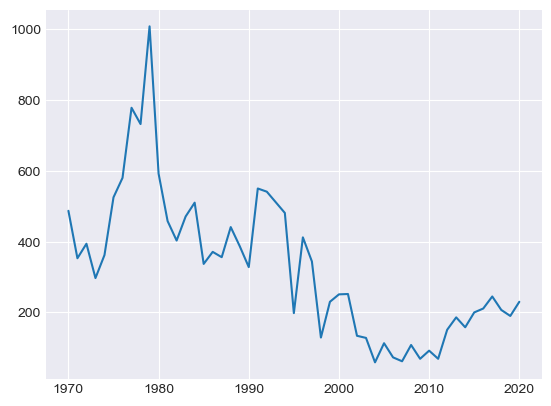

In [6]:

plt.plot(attentatiTotAnni)
plt.show()

In [7]:
attentatiNazioni = tr.groupby(['country_name','year']).count()['day']
attentatiNazioni = attentatiNazioni.reset_index().rename(columns={"day":"nAtt"})

In [8]:

# per scatter plot o color palette uniformi
'''
mapping_gruppi = {
    'United States': 0,
    'Italy': 1, 
    'United Kingdom': 2,
    'Spain': 3,
    'France': 4     
}

tr['gruppo'] = tr['country_name'].map(mapping_gruppi)
'''

# per boxplot e grafici con colori delle nazioni specifici
countries_color = {
    'United States': '#1F77B4',
    'Italy': '#2CA02C', 
    'United Kingdom': '#D62728',
    'Spain': '#FF7F0E',
    'France': '#9467BD'   
}

In [9]:
maxAtNazioni = tr.groupby("country_name").count()['day'].reset_index().rename(columns={"day":"nAtt"}).sort_values("nAtt", ascending=False)
maxAtNazioni

,country_name,nAtt
3,United Kingdom,5513
2,Spain,3255
4,United States,3121
0,France,2751
1,Italy,1603


<Axes: xlabel='year', ylabel='nAtt'>

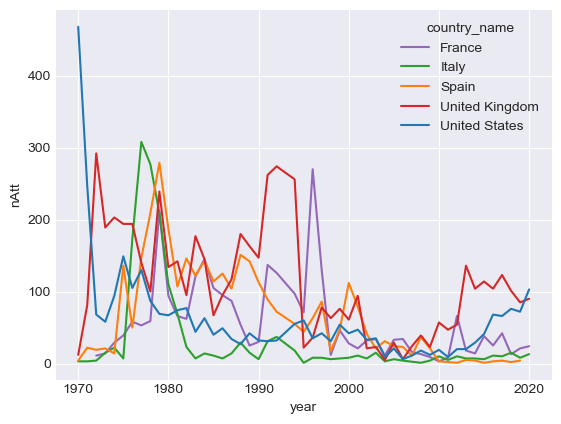

In [10]:
# lineplot
sns.lineplot(attentatiNazioni, x="year", y="nAtt", hue="country_name", palette=countries_color)

Text(0.5, 1.0, 'Numero di attentati dal 1970 al 2020')

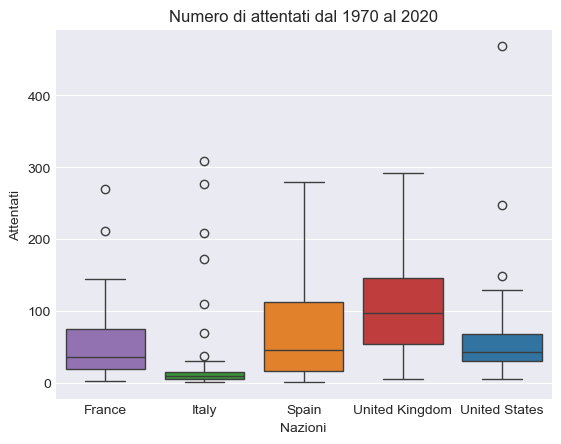

In [11]:
#boxplot
#plt.figure(figsize=(13,10))
ax = sns.boxplot(attentatiNazioni, x="country_name", y="nAtt", hue="country_name", palette=countries_color, whis=2)
ax.set_xlabel("Nazioni")
ax.set_ylabel("Attentati")
ax.set_title("Numero di attentati dal 1970 al 2020")
# l'italia ha troppi outliers

Text(0.5, 1.0, 'Numero di attentati dal 1970 al 2020')

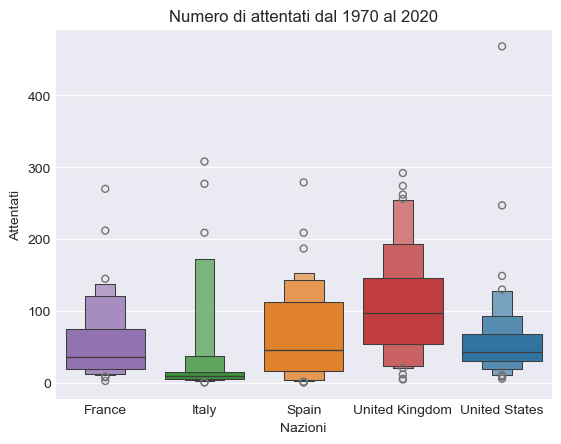

In [12]:
ax = sns.boxenplot(attentatiNazioni, x="country_name", y="nAtt", hue="country_name", k_depth="proportion", outlier_prop=0.2, palette=countries_color)
ax.set_xlabel("Nazioni")
ax.set_ylabel("Attentati")
ax.set_title("Numero di attentati dal 1970 al 2020")

### Attentati con riscatto?

In [13]:
attNazRansom = tr[tr['ransom'] > 0].groupby('country_name', as_index=True).count()[['day', 'ransom','ransompaid']].rename(columns={"day":"nAtt"})
attNazRansom
attNazNOR = tr.groupby('country_name', as_index=True).count()[['day', 'ransom','ransompaid']].rename(columns={"day":"nAtt"})

Text(0.5, 1.0, 'Rappresentazione del numero di attentati con riscatto sul numero totale fino al 2020')

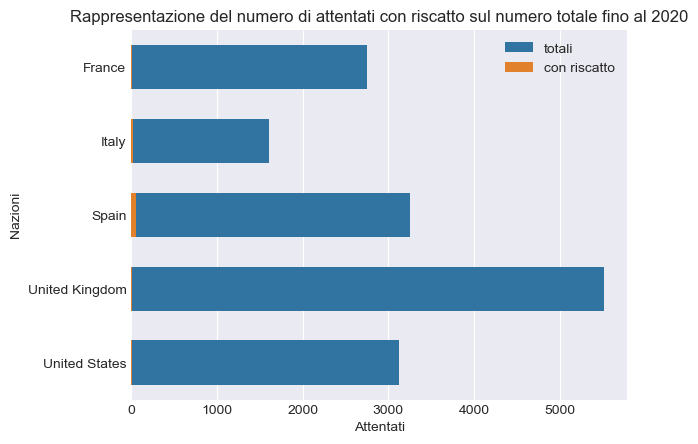

In [14]:
ax = sns.barplot(attNazNOR, x="nAtt", y="country_name", label="totali", width=0.6)
ax = sns.barplot(attNazRansom, x="ransom", y="country_name", label="con riscatto", width=0.6)
ax.legend()
ax.set_xlabel("Attentati")
ax.set_ylabel("Nazioni")
ax.set_title("Rappresentazione del numero di attentati con riscatto sul numero totale fino al 2020")

### Numero di attentati in Italia per ogni regione

In [15]:
regItaAtt = tr[tr['country_name'] == 'Italy'].groupby("provstate").count()['day']

<BarContainer object of 21 artists>

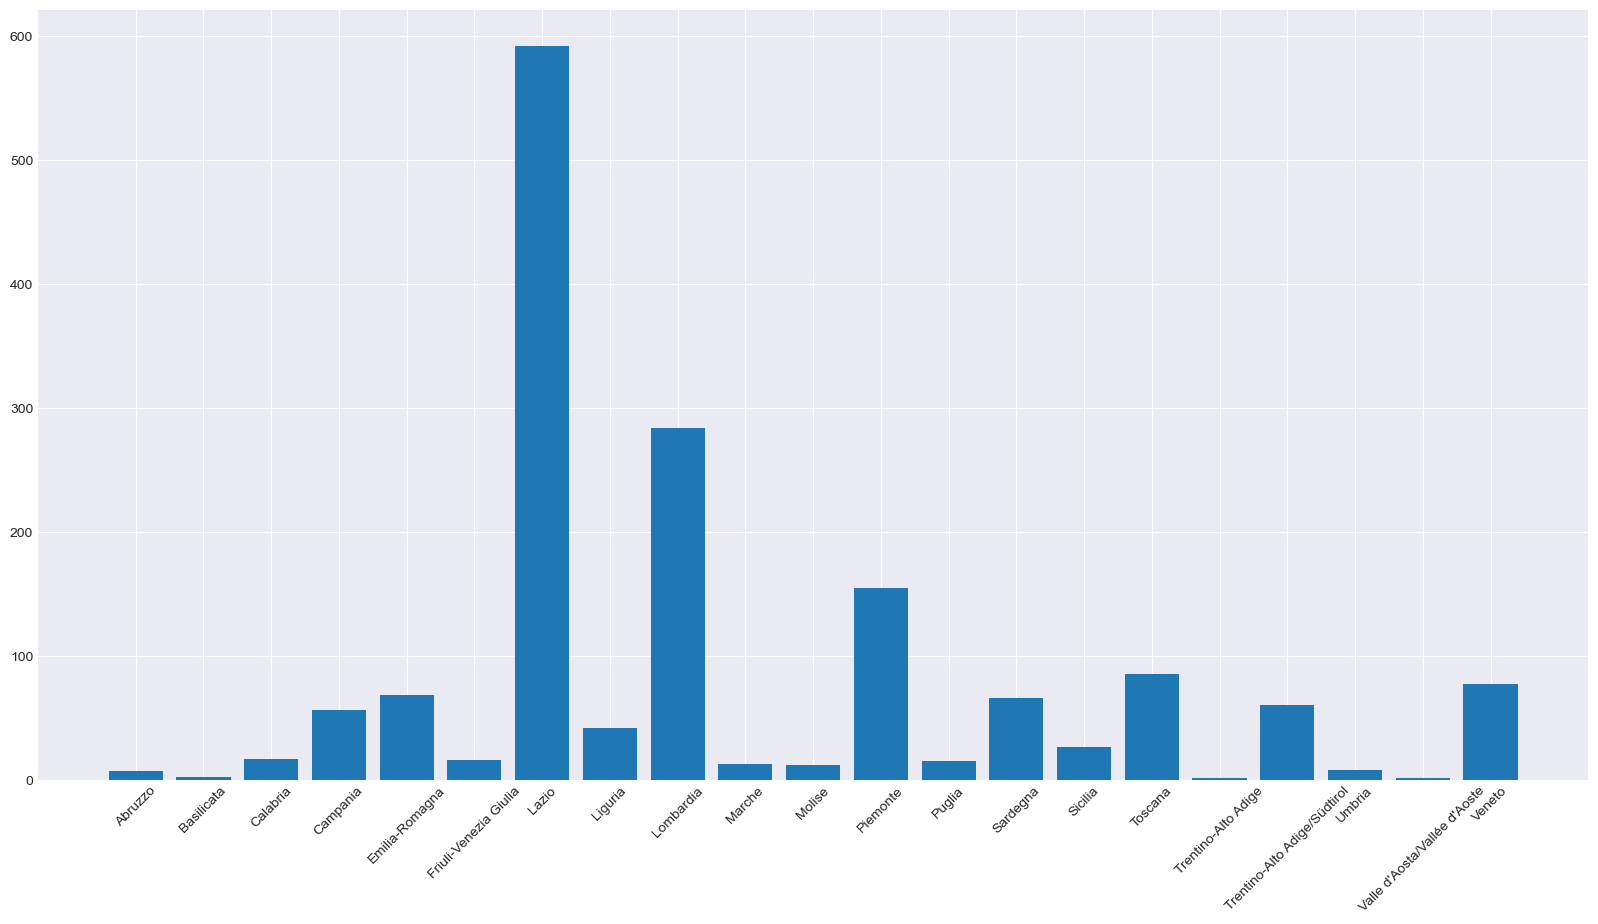

In [16]:
plt.figure(figsize=(20,10))
plt.xticks(rotation=45)
plt.bar(regItaAtt.index, regItaAtt.values)

## Cartina degli attentati totali in Italia

In [17]:
# url = "https://github.com/openpolis/geojson-italy/blob/master/geojson/limits_IT_regions.geojson"
itaMapName = "limits_IT_regions.geojson"
pathItaMap = os.path.abspath(os.path.join(os.pardir, "data", "itaMap"))

regItaAtt = tr[tr['country_name'] == 'Italy'].groupby("provstate").count()['day']
geoRegioniItalia = gpd.read_file(os.path.join(pathItaMap, itaMapName))

In [18]:
geoAttentatiItaTOT = geoRegioniItalia.merge(regItaAtt,left_on="reg_name", right_on="provstate", how="inner").rename(columns={"day":"nAtt"})

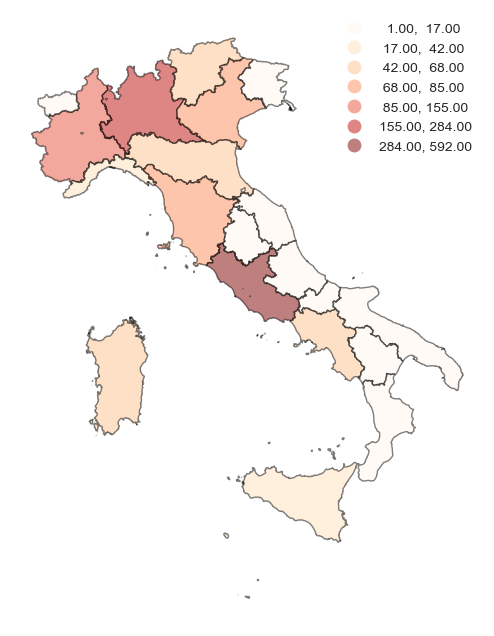

In [19]:
ax = geoAttentatiItaTOT.plot(
    figsize=(8,8),
    column='nAtt',
    alpha=0.5, 
    edgecolor='k',
    scheme="fisher_jenks",
    k=7,
    cmap="OrRd",
    legend=True)
ax.set_axis_off()
# ax.get_figure().savefig("test.svg",format="svg")

In [20]:
# Fare per ogni anno e unire in una gif
'''
def setK(values):
    if np.count_nonzero(values) == pd.count(pd.unique(values)):
        return np.count_nonzero(values)
    else:'''

import pathlib

image_files = []
regItaAttAnnuale = tr[(tr['country_name'] == 'Italy')].groupby(['year','provstate']).count()['day']
regItaAttAnnuale = regItaAttAnnuale.reset_index()

def stampaIta(a, start):
    

    geoAttentatiItaAnnuale = geoRegioniItalia.merge(regItaAttAnnuale[(regItaAttAnnuale['year'] >= start) & (regItaAttAnnuale['year'] <= a)].groupby(['provstate']).sum(),left_on="reg_name", right_on="provstate", how="left").rename(columns={"day":"nAtt"}).replace({np.nan:0}).drop('year',axis=1)

    anim_path = pathlib.Path("gif/")
    anim_path.mkdir(parents=True, exist_ok=True)

    countRegioniAtt = len(pd.unique(geoAttentatiItaAnnuale['nAtt']))
    
    ax = geoAttentatiItaAnnuale.plot(
        figsize=(8,8),
        column='nAtt',
        alpha=0.5, 
        edgecolor='k',
        #categorical=True, # da controllare se è troppo rigido --> si
        scheme="fisher_jenks",
        k = countRegioniAtt if countRegioniAtt < 7 else 7,
        cmap="OrRd",
        legend=True)
    ax.set_axis_off()
    ax.set_title(
    "Attentati fino al "+str(a),
    fontsize=20
    )

    plt.close()
    
    file_name = "gif_images/test"+str(a)+".png"
    ax.get_figure().savefig(file_name,format="png")
    image_files.append(file_name)

anni = np.arange(1970,2021)
for a in anni:
    stampaIta(a, 1970)


images = []

for file_name in image_files:
  images.append(imageio.imread(file_name))

gif_path = "attentati1970-2020ITA.gif"
imageio.mimsave(gif_path, images, fps=3)


/var/folders/nt/1mvzy58s2jq_741mrx9nm4mm0000gn/T/ipykernel_1113/469593221.py:54: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(file_name))


## Numero attentati per numero morti

In [21]:
mortiPerAnno = tr.groupby(['country_name','year']).sum('nkill')['nkill']
mortiPerAnno.loc['United States',:].head()


year
1970    33.0
1971    20.0
1972    10.0
1973    45.0
1974    16.0
Name: nkill, dtype: float64

In [22]:
'''
plt.figure(figsize = (8, 4) )
x = tr['nkill']
plt.xlabel("Numero di morti")
y = tr['year']
plt.ylabel("Anni")

scatter = plt.scatter(x, y, c=tr['gruppo'], s=10*tr['day'], alpha=0.3, )
plt.legend(frameon=True, framealpha=1, handles=scatter.legend_elements()[0], labels = ['United States', 'Italy', 'United Kingdom','Spain', 'France'])
plt.show()
'''

'\nplt.figure(figsize = (8, 4) )\nx = tr[\'nkill\']\nplt.xlabel("Numero di morti")\ny = tr[\'year\']\nplt.ylabel("Anni")\n\nscatter = plt.scatter(x, y, c=tr[\'gruppo\'], s=10*tr[\'day\'], alpha=0.3, )\nplt.legend(frameon=True, framealpha=1, handles=scatter.legend_elements()[0], labels = [\'United States\', \'Italy\', \'United Kingdom\',\'Spain\', \'France\'])\nplt.show()\n'

## Numero attentati per numero di vittime

In [23]:
'''plt.figure(figsize = (8, 4) )
x = tr['nwound']
plt.xlabel("Numero di feriti")
y = tr['year']
plt.ylabel("Anni")

plt.scatter(x, y, c=tr['gruppo'], s=10*tr['day'], alpha=0.1, cmap = 'viridis') 
plt.show()
'''

'plt.figure(figsize = (8, 4) )\nx = tr[\'nwound\']\nplt.xlabel("Numero di feriti")\ny = tr[\'year\']\nplt.ylabel("Anni")\n\nplt.scatter(x, y, c=tr[\'gruppo\'], s=10*tr[\'day\'], alpha=0.1, cmap = \'viridis\') \nplt.show()\n'

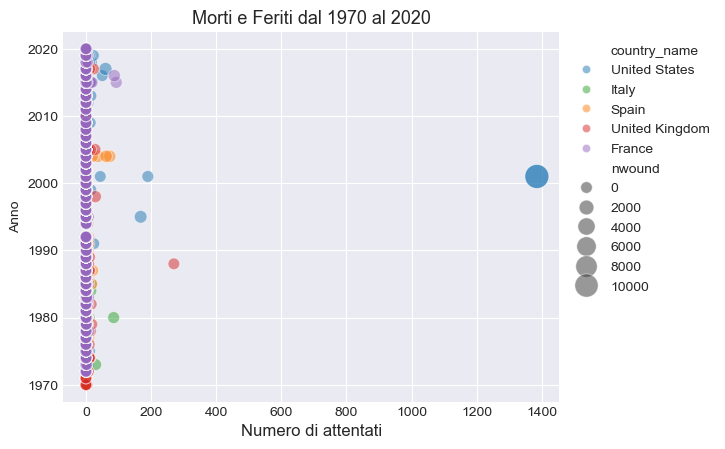

In [24]:
scatter = sns.scatterplot(
    tr, 
    x="nkill", 
    y="year", 
    alpha=0.5, 
    palette=countries_color, 
    hue="country_name",
    sizes=(70,300),
    size="nwound",
)
scatter.set_title("Morti e Feriti dal 1970 al 2020", fontsize=13)
scatter.set_xlabel("Numero di attentati", fontsize=12)
scatter.set_ylabel("Anno")
sns.move_legend(scatter, "upper left", bbox_to_anchor=(1, 1))

In [25]:
''' Cercare delle correlazioni nei dati!
    •   Perché spagna e italia hanno avuto quasi lo stesso andamento degli attentati?
    •   Riscatto e tipologia di attentato'''

' Cercare delle correlazioni nei dati!\n    •   Perché spagna e italia hanno avuto quasi lo stesso andamento degli attentati?\n    •   Riscatto e tipologia di attentato'

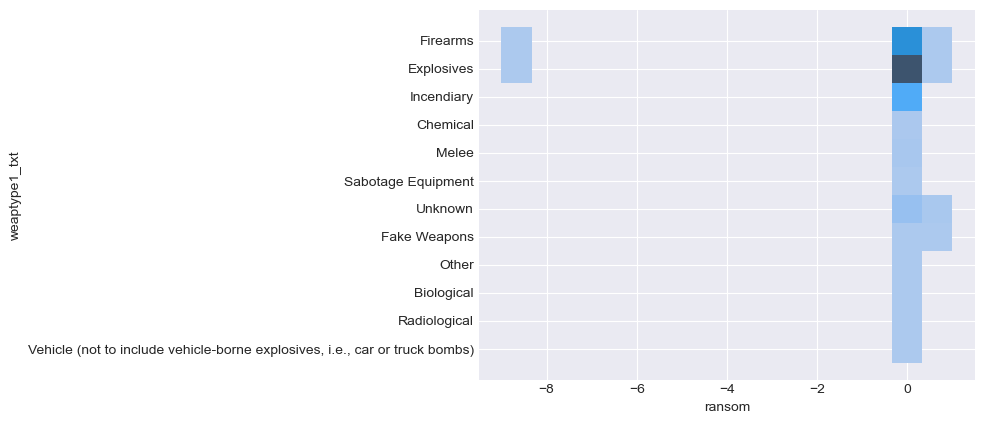

In [26]:
ax = sns.histplot(tr, y="weaptype1_txt", x="ransom")


<Axes: xlabel='ransom', ylabel='targtype1_txt'>

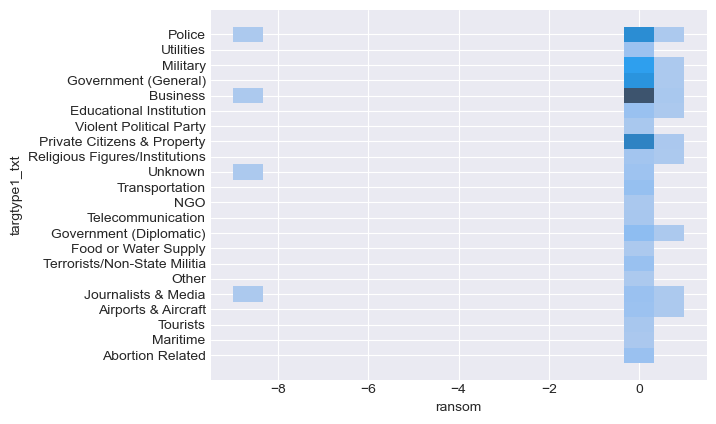

In [27]:
sns.histplot(tr, x="ransom", y="targtype1_txt")

<Axes: xlabel='ransom', ylabel='attacktype1_txt'>

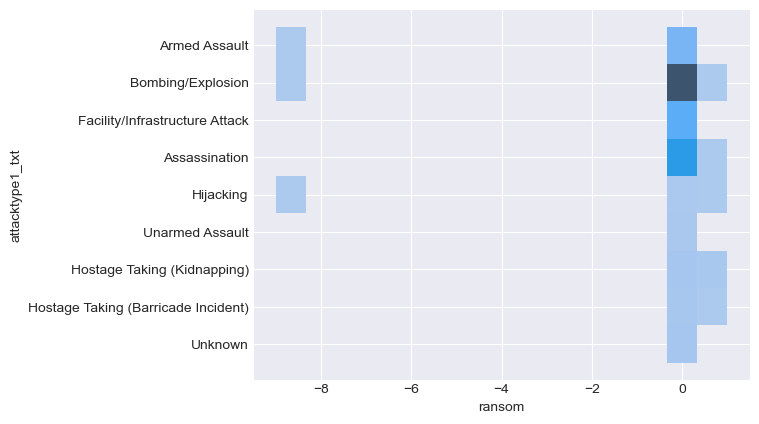

In [28]:
sns.histplot(tr, y="attacktype1_txt", x="ransom")

### Correlazione??

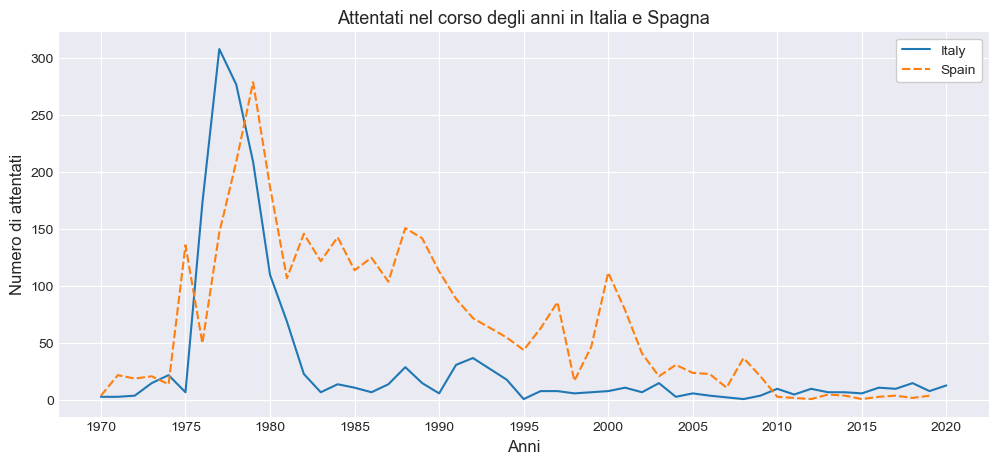

In [29]:
#attentatiNazioni = attentatiNazioni.reset_index()
plt.figure(figsize=(12,5))
itaEsp = attentatiNazioni[(attentatiNazioni["country_name"] == "Italy") | (attentatiNazioni["country_name"] == "Spain")]
ax = sns.lineplot(itaEsp, x="year", y="nAtt", hue="country_name", style="country_name")
ax.set(xticks=np.arange(1970,2025,5), yticks=np.arange(0,350,50))
ax.set_title("Attentati nel corso degli anni in Italia e Spagna", fontsize=13)
ax.set_ylabel("Numero di attentati", fontsize=12)
ax.set_xlabel("Anni", fontsize=12)
plt.legend(frameon=True, framealpha=1, facecolor="white")
plt.show()

In [30]:
gSpainAtt = tr[(tr['country_name'] == 'Spain') & ((tr['year'] > 1974) & (tr['year'] < 1985))].groupby('gname').count()['day'].reset_index().rename(columns={"day":"nAtt"}).sort_values("nAtt", ascending=False).head(10)

gItaAtt = tr[(tr['country_name'] == 'Italy') & ((tr['year'] > 1974) & (tr['year'] < 1985))].groupby('gname').count()['day'].reset_index().rename(columns={"day":"nAtt"}).sort_values("nAtt", ascending=False).head(10)

gSpainAtt

,gname,nAtt
16,Basque Fatherland and Freedom (ETA),892
61,Unknown,257
30,First of October Antifascist Resistance Group ...,157
47,Revolutionary Patriotic Anti-Fascist Front (FRAP),46
21,Canary Islands Independence Movement,34
11,Armenian Secret Army for the Liberation of Arm...,11
9,Argentine Anticommunist Alliance (AAA),10
13,Autonomous Anti-Capitalist Commandos (CAA),8
53,Spanish Basque Battalion (BBE) (rightist),7
46,Red Guerrilla,6


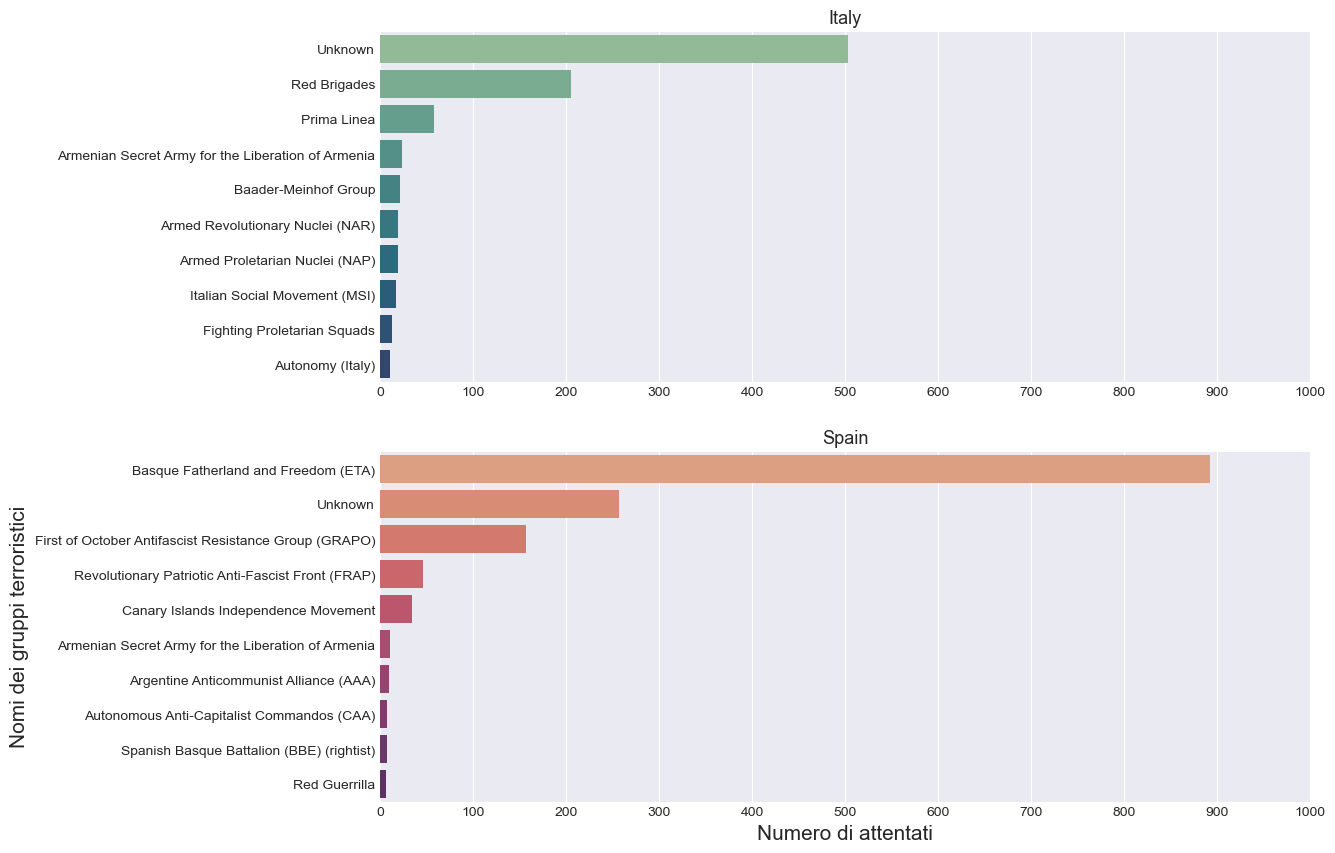

In [31]:
plt.figure(figsize=(12,10))

plt.subplot(2,1,1)
s1 = sns.barplot(gItaAtt, x="nAtt", y="gname", hue="gname", palette="crest", legend=False)
s1.set_xlim(0,1000)
s1.set_ylabel("")
s1.set_xlabel("")
s1.set_title("Italy", fontsize=13)
s1.set(xticks=np.arange(0,1100,100))

plt.subplot(2,1,2)
s2 = sns.barplot(gSpainAtt, x="nAtt", y="gname", hue="gname", palette="flare", legend=False)
s2.set_xlim(0,1000)
s2.set_ylabel("Nomi dei gruppi terroristici", fontsize=15)
s2.set_xlabel("Numero di attentati", fontsize=15)
s2.set_title("Spain", fontsize=13)
s2.set(xticks=np.arange(0,1100,100))

plt.show()

## Mappare i morti e feriti

In [32]:
tr.groupby('country_name', as_index=False).sum('nkill')[['country_name','nkill']].sort_values('nkill', ascending=False)

,country_name,nkill
4,United States,3926.0
3,United Kingdom,3426.0
2,Spain,1289.0
0,France,565.0
1,Italy,420.0


In [33]:
geoTr = gpd.GeoDataFrame(
    tr, geometry=gpd.points_from_xy(tr.longitude, tr.latitude)
)
geoTr.crs = "EPSG:4326"
#geoTr.head()

In [34]:

display(len(tr[tr["year"]== 1993]))

0

## Gruppi terroristici più frequenti (5)

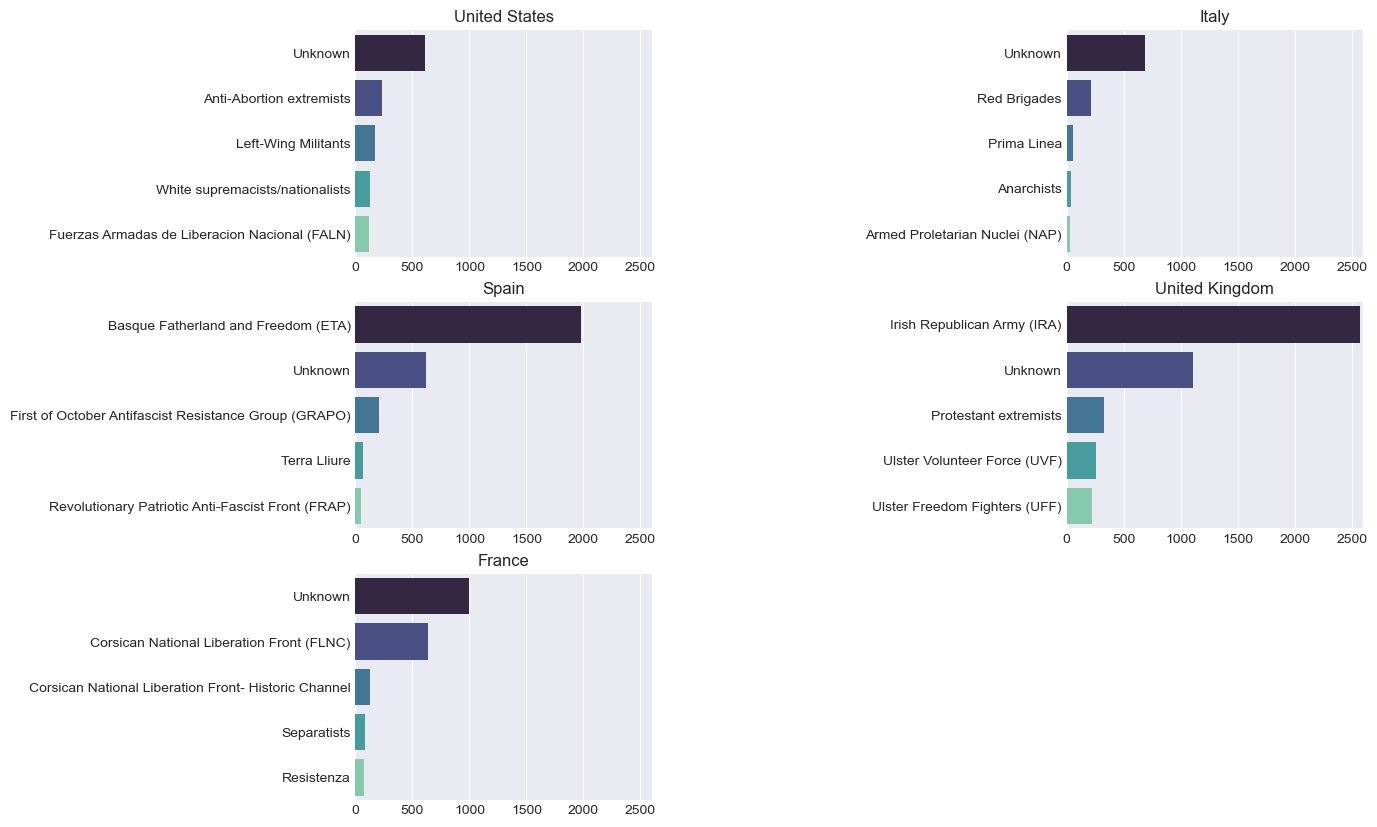

In [35]:
countries = pd.unique(tr['country_name'])
c = 0
plt.figure(figsize=(13,10))
for i in np.arange(0,7,1):

    if((i != 1) & (i != 4)):
        plt.subplot(3, 3, i+1)
        gFreqC = tr[tr['country_name'] == countries[c]].groupby(['gname'], as_index=True).count()['day'].sort_values(ascending=False).head(5)
        gFreqC = gFreqC.reset_index().rename(columns={"day":"nAtt"})
        s = sns.barplot(gFreqC, y='gname', x='nAtt', hue="gname", palette="mako")
        #s.tick_params(axis='x', labelrotation=90)
        s.set_title(countries[c], fontsize=12)
        s.set_xlim(0,2600)
        s.set_xlabel("")
        s.set_ylabel("")
        c+=1
    else:
        c+=0

### I gruppi terroristici che hanno fatto più vittime

In [36]:
topGName = tr.groupby(["gname"]).sum("nkill").sort_values(by=["nkill","nwound"], ascending=False).head(10)[["nkill","nwound"]]
topGName

,nkill,nwound
gname,,
Al-Qaida,3251.0,24456.0
Irish Republican Army (IRA),1743.0,3665.0
Basque Fatherland and Freedom (ETA),819.0,2344.0
Unknown,653.0,1732.0
Protestant extremists,340.0,155.0
Ulster Volunteer Force (UVF),328.0,25.0
Jihadi-inspired extremists,256.0,784.0
Anti-Government extremists,248.0,1581.0
Ulster Freedom Fighters (UFF),197.0,66.0


<Axes: xlabel='nkill', ylabel='nwound'>

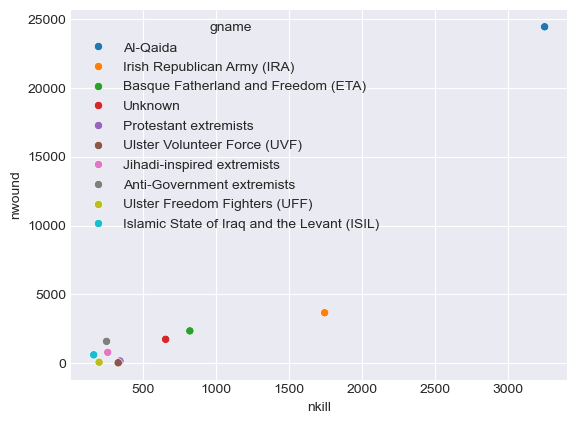

In [37]:
sns.scatterplot(topGName.reset_index(), x="nkill", y="nwound", hue="gname")

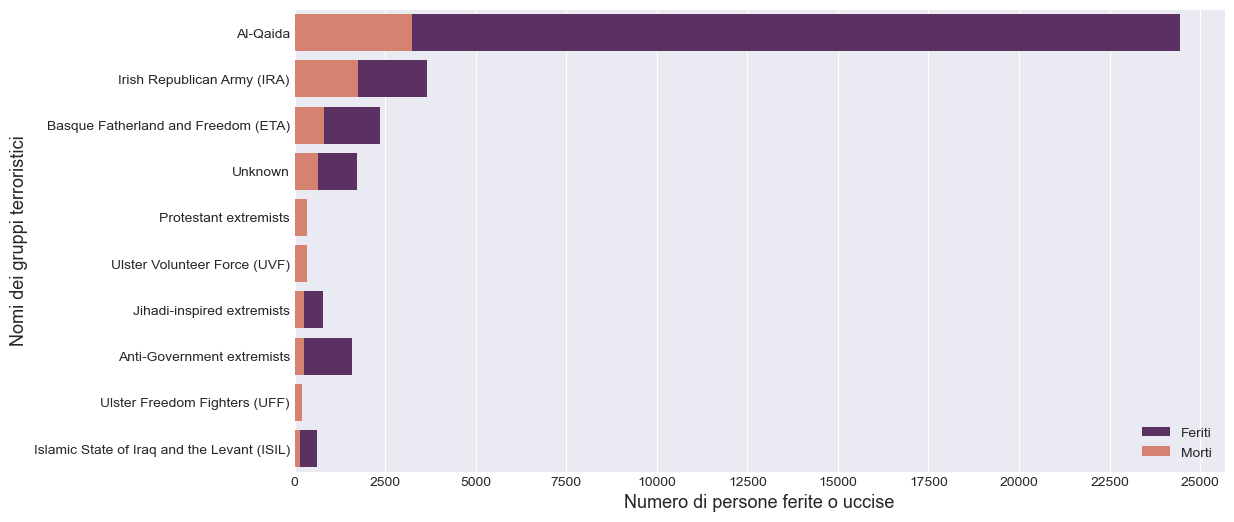

In [38]:
plt.figure(figsize=(12,6))
ax = sns.barplot(topGName, x="nwound", y="gname", label="Feriti", color="#612969")
ax = sns.barplot(topGName, x="nkill", y="gname", label="Morti", color="#E67760")
ax.set_xlabel("Numero di persone ferite o uccise",fontsize=13)
ax.set_ylabel("Nomi dei gruppi terroristici", fontsize=13)
plt.legend(facecolor="white",framealpha=1)
ax.set(xticks=np.arange(0,27500,2500))

plt.show()

### I 5 attentati di ogni nazione con maggior numero di morti

In [39]:

unionTopFive = pd.DataFrame()
for c in countries:
    current = tr[tr["country_name"] == c].sort_values(by="nkill",ascending=False)[["country_name","day","month","year","provstate","city","summary","gname","targtype1_txt","weaptype1_txt","nkill","nwound","latitude","longitude"]].head(5)
    unionTopFive = pd.concat([unionTopFive, current])

labels = pd.Series(["Twin Towers 1","Twin Towers 2","Pentagon attack","Oklaoma City Bombing","Las Vegas Shooting",
                    "Strage di Bologna", "Attentato di fiumicino (Settembre Nero) 1", "Attentato di fiumicino (Settembre Nero) 2", "Attentato di fiumicino (A.N.O.)", "Strage del Rapido 904",
                    "Train explodes at El Pozo Station","Train explodes near Atocha Station","Train explodes at Atocha Station", "Hipercor Bombing","Train explodes passing through Santa Eugenia Station",
                    "Fly Pan Am 103","Omagh bombing","London Metro Bombing","Manchester Bombing","Warrenpoint Ambush",
                    "Bataclan Concert Hall","Nizza massacre","La Belle Equipe bar in 11th arrondissement","Le Carillon and Le Petit Cambodge restaurants","Charlie Hebdo massacre"])

unionTopFive["annotateOnly"] = labels.values


/usr/local/lib/python3.12/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/var/folders/nt/1mvzy58s2jq_741mrx9nm4mm0000gn/T/ipykernel_1113/3484667085.py:9: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  axIta = mortiIta.plot(column='nkill', alpha=0.4, marker='o', color="black",label="Morti",figsize=(8, 8), markersize="nkill")


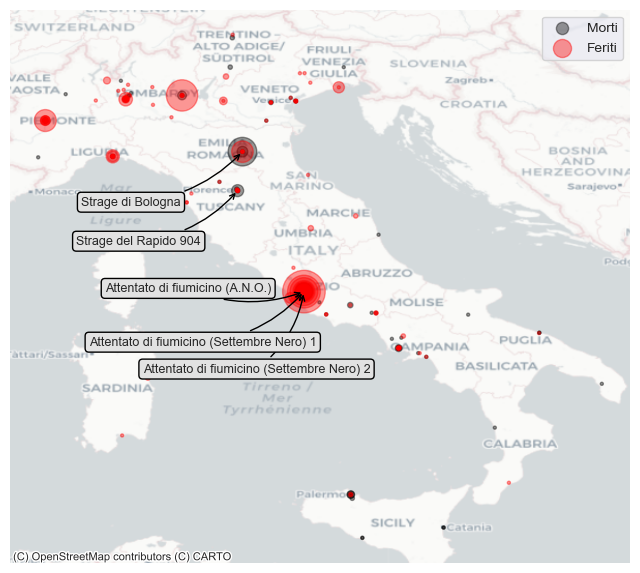

In [40]:
topIta = unionTopFive[unionTopFive["country_name"] == "Italy"]

mortiIta = geoTr[(geoTr['country_name'] == 'Italy') & (geoTr['nkill'] > 0)]
feritiIta = geoTr[(geoTr['country_name'] == 'Italy') & (geoTr['nwound'] > 0)]

mortiIta['nkill'] *= 5 # scalo la visualizzazione dei marker nel grafico in modo da renderli più visibilis
feritiIta['nwound'] *= 5

axIta = mortiIta.plot(column='nkill', alpha=0.4, marker='o', color="black",label="Morti",figsize=(8, 8), markersize="nkill")
feritiIta.plot(ax=axIta, marker='o', color='red', alpha=0.4, label="Feriti", figsize=(8, 8), markersize="nwound")

ctx.add_basemap(
    axIta,
    crs=geoTr.crs.to_string(),
    zoom=6,
    source=ctx.providers.CartoDB.Positron
    #source=ctx.providers.OpenStreetMap.Mapnik
)
axIta.legend(frameon=True, markerscale=0.6)
axIta.set_axis_off()

''' Putroppo automatizzando il processo le coordinate delle label non erano troppo modificabili e si accumulavano una sopra l'altra
for l in range(0, length):
    axIta.annotate(topIta.iloc[l,:]["annotateOnly"],
                    xy=(topIta.iloc[l,:]["longitude"], topIta.iloc[l,:]["latitude"]), 
                 xytext=(topIta.iloc[l,:]["longitude"]-random.randint(2, 4), topIta.iloc[l,:]["latitude"]-random.randint(1, 2)), xycoords='data', textcoords='data',
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2", color='black'), size=9,
             bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='#e2e2e2'))
'''
axIta.annotate(topIta.iloc[0,:]["annotateOnly"],
                xy=(topIta.iloc[0,:]["longitude"], topIta.iloc[0,:]["latitude"]), 
                xytext=(topIta.iloc[0,:]["longitude"]-3, topIta.iloc[0,:]["latitude"]-1), xycoords='data', textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2", color='black'), size=9,
            bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='#e2e2e2'))
axIta.annotate(topIta.iloc[2,:]["annotateOnly"],
                xy=(topIta.iloc[2,:]["longitude"], topIta.iloc[2,:]["latitude"]), 
                xytext=(topIta.iloc[2,:]["longitude"]-3, topIta.iloc[2,:]["latitude"]-1.5), xycoords='data', textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2", color='black'), size=9,
            bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='#e2e2e2'))
axIta.annotate(topIta.iloc[1,:]["annotateOnly"],
                xy=(topIta.iloc[1,:]["longitude"], topIta.iloc[1,:]["latitude"]), 
                xytext=(topIta.iloc[1,:]["longitude"]-4, topIta.iloc[1,:]["latitude"]-1), xycoords='data', textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2", color='black'), size=9,
            bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='#e2e2e2'))
axIta.annotate(topIta.iloc[3,:]["annotateOnly"],
                xy=(topIta.iloc[3,:]["longitude"], topIta.iloc[3,:]["latitude"]), 
                xytext=(topIta.iloc[3,:]["longitude"]-3.7, topIta.iloc[3,:]["latitude"]), xycoords='data', textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2", color='black'), size=9,
            bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='#e2e2e2'))
axIta.annotate(topIta.iloc[4,:]["annotateOnly"],
                xy=(topIta.iloc[4,:]["longitude"], topIta.iloc[4,:]["latitude"]), 
                xytext=(topIta.iloc[4,:]["longitude"]-3, topIta.iloc[4,:]["latitude"]-1), xycoords='data', textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2", color='black'), size=9,
            bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='#e2e2e2'))
#axIta.get_figure().savefig("itaImg.pdf",format="pdf")
plt.show()

/usr/local/lib/python3.12/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/var/folders/nt/1mvzy58s2jq_741mrx9nm4mm0000gn/T/ipykernel_1113/2140645313.py:9: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  axFr = mortiFr.plot(column='nkill', alpha=0.7, marker='o', color="black", label="Morti", figsize=(10, 10), markersize="nkill")


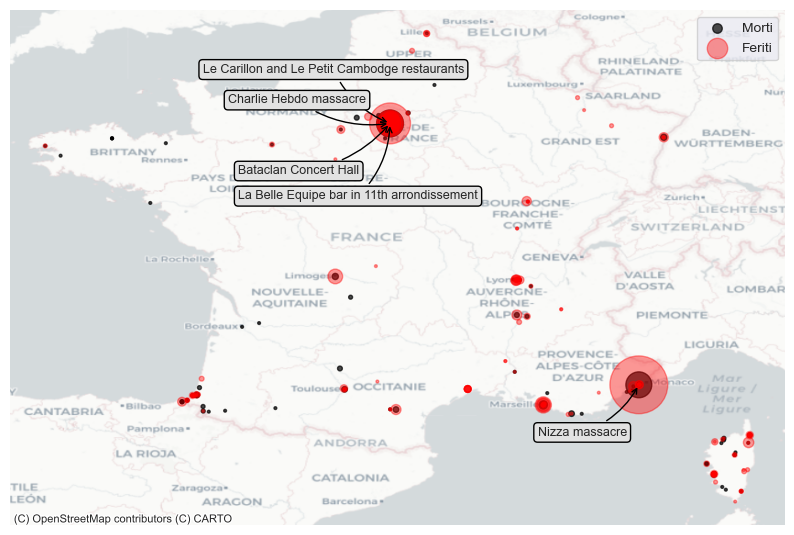

In [41]:
topFr = unionTopFive[unionTopFive["country_name"] == "France"]

mortiFr = geoTr[(geoTr['country_name'] == 'France') & (geoTr['nkill'] > 0)]
feritiFr = geoTr[(geoTr['country_name'] == 'France') & (geoTr['nwound'] > 0)]

mortiFr['nkill'] *= 4 #in modo da ingrandire i marker dinamicamente
feritiFr['nwound'] *= 4

axFr = mortiFr.plot(column='nkill', alpha=0.7, marker='o', color="black", label="Morti", figsize=(10, 10), markersize="nkill")
feritiFr.plot(ax=axFr, marker='o', color='red', alpha=0.4, label="Feriti",figsize=(10, 10), markersize="nwound")
ctx.add_basemap(
    axFr,
    crs=geoTr.crs.to_string(),
    zoom=6,
    source=ctx.providers.CartoDB.Positron
    #source=ctx.providers.OpenStreetMap.Mapnik
)
axFr.legend(frameon=True, markerscale=0.5)
axFr.set_axis_off()
#axFr.get_figure().savefig("ukImg.pdf",format="pdf")
axFr.annotate(topFr.iloc[0,:]["annotateOnly"],
                xy=(topFr.iloc[0,:]["longitude"], topFr.iloc[0,:]["latitude"]), 
                xytext=(topFr.iloc[0,:]["longitude"]-3, topFr.iloc[0,:]["latitude"]-1), xycoords='data', textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2", color='black'), size=9,
            bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='#e2e2e2'))

axFr.annotate(topFr.iloc[2,:]["annotateOnly"],
                xy=(topFr.iloc[2,:]["longitude"], topFr.iloc[2,:]["latitude"]), 
                xytext=(topFr.iloc[2,:]["longitude"]-3, topFr.iloc[2,:]["latitude"]-1.5), xycoords='data', textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2", color='black'), size=9,
            bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='#e2e2e2'))

axFr.annotate(topFr.iloc[1,:]["annotateOnly"],
                xy=(topFr.iloc[1,:]["longitude"], topFr.iloc[1,:]["latitude"]), 
                xytext=(topFr.iloc[1,:]["longitude"]-2, topFr.iloc[1,:]["latitude"]-1), xycoords='data', textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2", color='black'), size=9,
            bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='#e2e2e2'))

axFr.annotate(topFr.iloc[3,:]["annotateOnly"],
                xy=(topFr.iloc[3,:]["longitude"], topFr.iloc[3,:]["latitude"]), 
                xytext=(topFr.iloc[3,:]["longitude"]-3.7, topFr.iloc[3,:]["latitude"]+1), xycoords='data', textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2", color='black'), size=9,
            bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='#e2e2e2'))

axFr.annotate(topFr.iloc[4,:]["annotateOnly"],
                xy=(topFr.iloc[4,:]["longitude"], topFr.iloc[4,:]["latitude"]), 
                xytext=(topFr.iloc[4,:]["longitude"]-3.2, topFr.iloc[4,:]["latitude"]+0.4), xycoords='data', textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2", color='black'), size=9,
            bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='#e2e2e2'))
plt.show()
            

/usr/local/lib/python3.12/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/var/folders/nt/1mvzy58s2jq_741mrx9nm4mm0000gn/T/ipykernel_1113/1120209188.py:9: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  axEsp = mortiEsp.plot(column='nkill', alpha=0.6, marker='o', color="black", label="Morti", figsize=(10, 10), markersize="nkill")


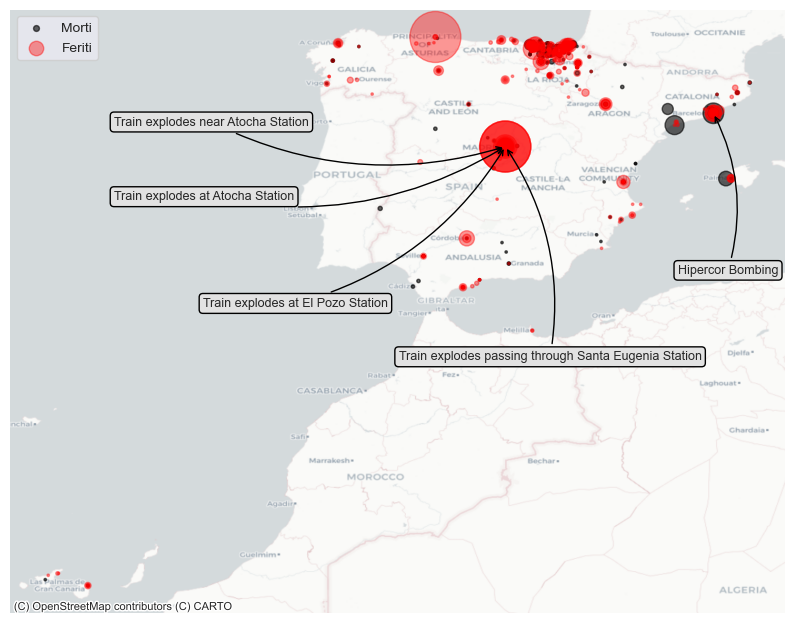

In [42]:
topEsp = unionTopFive[unionTopFive["country_name"] == "Spain"]

mortiEsp = geoTr[(geoTr['country_name'] == 'Spain') & (geoTr['nkill'] > 0)]
feritiEsp = geoTr[(geoTr['country_name'] == 'Spain') & (geoTr['nwound'] > 0)]

mortiEsp['nkill'] *= 3 #in modo da ingrandire i marker dinamicamente
feritiEsp['nwound'] *= 3

axEsp = mortiEsp.plot(column='nkill', alpha=0.6, marker='o', color="black", label="Morti", figsize=(10, 10), markersize="nkill")
feritiEsp.plot(ax=axEsp, marker='o', color='red', alpha=0.4, label="Feriti",figsize=(10, 10), markersize="nwound")
ctx.add_basemap(
    axEsp,
    crs=geoTr.crs.to_string(),
    zoom=6,
    source=ctx.providers.CartoDB.Positron
    #source=ctx.providers.OpenStreetMap.Mapnik
)
axEsp.legend(frameon=True, loc="upper left", markerscale=0.4)
axEsp.set_axis_off()
#axEsp.get_figure().savefig("ukImg.pdf",format="pdf")
axEsp.annotate(topEsp.iloc[0,:]["annotateOnly"],
                xy=(topEsp.iloc[0,:]["longitude"], topEsp.iloc[0,:]["latitude"]), 
                xytext=(topEsp.iloc[0,:]["longitude"]-8.5, topEsp.iloc[0,:]["latitude"]-4.5), xycoords='data', textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2", color='black'), size=9,
            bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='#e2e2e2'))

axEsp.annotate(topEsp.iloc[2,:]["annotateOnly"],
                xy=(topEsp.iloc[2,:]["longitude"], topEsp.iloc[2,:]["latitude"]), 
                xytext=(topEsp.iloc[2,:]["longitude"]-11, topEsp.iloc[2,:]["latitude"]-1.5), xycoords='data', textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2", color='black'), size=9,
            bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='#e2e2e2'))

axEsp.annotate(topEsp.iloc[1,:]["annotateOnly"],
                xy=(topEsp.iloc[1,:]["longitude"], topEsp.iloc[1,:]["latitude"]), 
                xytext=(topEsp.iloc[1,:]["longitude"]-11, topEsp.iloc[1,:]["latitude"]+0.6), xycoords='data', textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2", color='black'), size=9,
            bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='#e2e2e2'))

axEsp.annotate(topEsp.iloc[3,:]["annotateOnly"],
                xy=(topEsp.iloc[3,:]["longitude"], topEsp.iloc[3,:]["latitude"]), 
                xytext=(topEsp.iloc[3,:]["longitude"]-1, topEsp.iloc[3,:]["latitude"]-4.5), xycoords='data', textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2", color='black'), size=9,
            bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='#e2e2e2'))

axEsp.annotate(topEsp.iloc[4,:]["annotateOnly"],
                xy=(topEsp.iloc[4,:]["longitude"], topEsp.iloc[4,:]["latitude"]), 
                xytext=(topEsp.iloc[4,:]["longitude"]-3, topEsp.iloc[4,:]["latitude"]-6), xycoords='data', textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2", color='black'), size=9,
            bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='#e2e2e2'))
plt.show()

/usr/local/lib/python3.12/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/var/folders/nt/1mvzy58s2jq_741mrx9nm4mm0000gn/T/ipykernel_1113/3467203998.py:9: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  axUk = mortiUk.plot(column='nkill', alpha=0.5, marker='o', color="black", label="Morti", figsize=(10, 10), markersize="nkill")


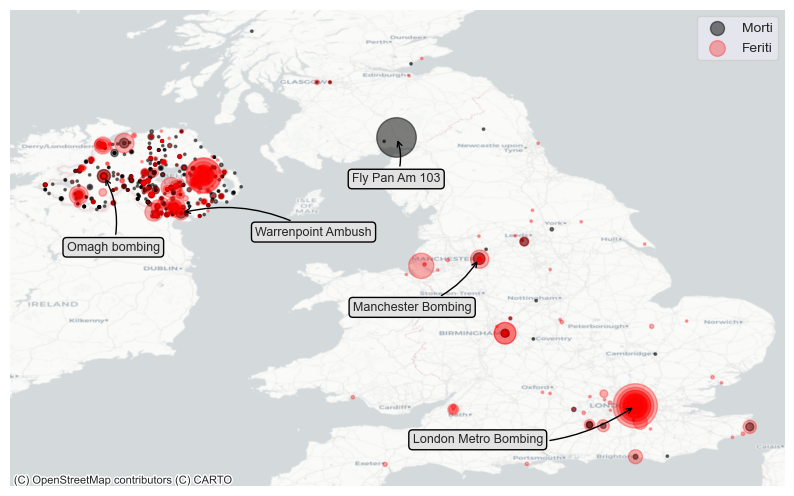

In [43]:
topUk = unionTopFive[unionTopFive["country_name"] == "United Kingdom"]

mortiUk = geoTr[(geoTr['country_name'] == 'United Kingdom') & (geoTr['nkill'] > 0)]
feritiUk = geoTr[(geoTr['country_name'] == 'United Kingdom') & (geoTr['nwound'] > 0)]

mortiUk['nkill'] *= 3 #in modo da ingrandire i marker dinamicamente
feritiUk['nwound'] *= 3

axUk = mortiUk.plot(column='nkill', alpha=0.5, marker='o', color="black", label="Morti", figsize=(10, 10), markersize="nkill")
feritiUk.plot(ax=axUk, marker='o', color='red', alpha=0.3, label="Feriti",figsize=(10, 10), markersize="nwound")
ctx.add_basemap(
    axUk,
    crs=geoTr.crs.to_string(),
    zoom=7,
    source=ctx.providers.CartoDB.Positron
    #source=ctx.providers.OpenStreetMap.Mapnik
)
axUk.legend(frameon=True, markerscale=0.5)
axUk.set_axis_off()
#axUk.get_figure().savefig("ukImg.pdf",format="pdf")

axUk.annotate(topUk.iloc[0,:]["annotateOnly"],
                xy=(topUk.iloc[0,:]["longitude"], topUk.iloc[0,:]["latitude"]), 
                xytext=(topUk.iloc[0,:]["longitude"]-0.6, topUk.iloc[0,:]["latitude"]-0.6), xycoords='data', textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2", color='black'), size=9,
            bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='#e2e2e2'))

axUk.annotate(topUk.iloc[2,:]["annotateOnly"],
                xy=(topUk.iloc[2,:]["longitude"], topUk.iloc[2,:]["latitude"]), 
                xytext=(topUk.iloc[2,:]["longitude"]-3, topUk.iloc[2,:]["latitude"]-0.5), xycoords='data', textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2", color='black'), size=9,
            bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='#e2e2e2'))

axUk.annotate(topUk.iloc[1,:]["annotateOnly"],
                xy=(topUk.iloc[1,:]["longitude"], topUk.iloc[1,:]["latitude"]), 
                xytext=(topUk.iloc[1,:]["longitude"]-0.5, topUk.iloc[1,:]["latitude"]-1), xycoords='data', textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2", color='black'), size=9,
            bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='#e2e2e2'))

axUk.annotate(topUk.iloc[3,:]["annotateOnly"],
                xy=(topUk.iloc[3,:]["longitude"], topUk.iloc[3,:]["latitude"]), 
                xytext=(topUk.iloc[3,:]["longitude"]-1.7, topUk.iloc[3,:]["latitude"]-0.7), xycoords='data', textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2", color='black'), size=9,
            bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='#e2e2e2'))

axUk.annotate(topUk.iloc[4,:]["annotateOnly"],
                xy=(topUk.iloc[4,:]["longitude"], topUk.iloc[4,:]["latitude"]), 
                xytext=(topUk.iloc[4,:]["longitude"]+1, topUk.iloc[4,:]["latitude"]-0.3), xycoords='data', textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2", color='black'), size=9,
            bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='#e2e2e2'))
plt.show()

/usr/local/lib/python3.12/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/var/folders/nt/1mvzy58s2jq_741mrx9nm4mm0000gn/T/ipykernel_1113/2457494963.py:9: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  axUsa = mortiUsa.plot(column='nkill', alpha=0.5, marker='o', color="black", label="Morti", figsize=(15, 15), markersize="nkill")


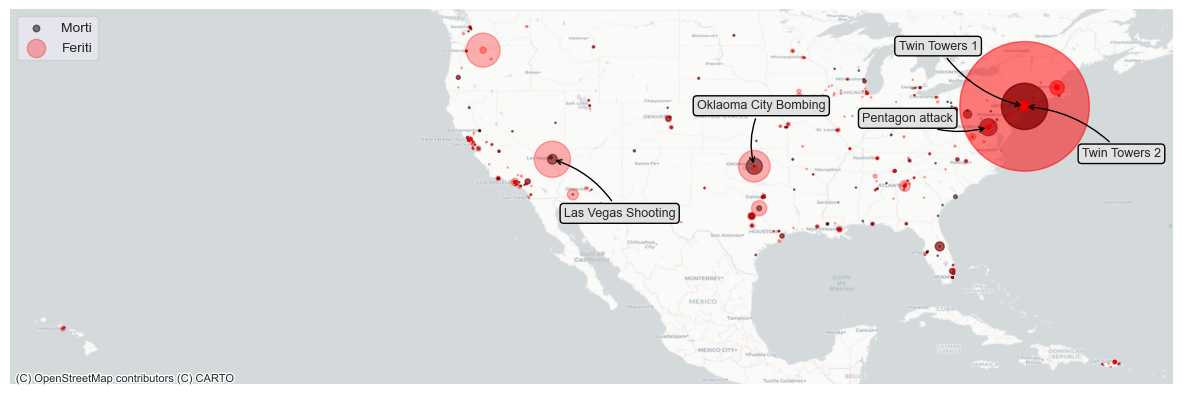

In [44]:
topUsa = unionTopFive[unionTopFive["country_name"] == "United States"]

mortiUsa = geoTr[(geoTr['country_name'] == 'United States') & (geoTr['nkill'] > 0)]
feritiUsa = geoTr[(geoTr['country_name'] == 'United States') & (geoTr['nwound'] > 0)]

mortiUsa['nkill'] *= 0.8 # scalo la visualizzazione
feritiUsa['nwound'] *= 0.8

axUsa = mortiUsa.plot(column='nkill', alpha=0.5, marker='o', color="black", label="Morti", figsize=(15, 15), markersize="nkill")
feritiUsa.plot(ax=axUsa, marker='o', color='red', alpha=0.3, label="Feriti",figsize=(15, 15), markersize="nwound")
ctx.add_basemap(
    axUsa,
    crs=geoTr.crs.to_string(),
    zoom=5,
    source=ctx.providers.CartoDB.Positron
    #source=ctx.providers.OpenStreetMap.Mapnik
)
axUsa.legend(frameon=True, loc="upper left", markerscale=0.2)
axUsa.set_axis_off()
#axUsa.get_figure().savefig("usaImg.pdf",format="pdf")

axUsa.annotate(topUsa.iloc[0,:]["annotateOnly"],
                xy=(topUsa.iloc[0,:]["longitude"], topUsa.iloc[0,:]["latitude"]), 
                xytext=(topUsa.iloc[0,:]["longitude"]-11, topUsa.iloc[0,:]["latitude"]+5), xycoords='data', textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2", color='black'), size=9,
            bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='#e2e2e2'))

axUsa.annotate(topUsa.iloc[2,:]["annotateOnly"],
                xy=(topUsa.iloc[2,:]["longitude"], topUsa.iloc[2,:]["latitude"]), 
                xytext=(topUsa.iloc[2,:]["longitude"]-11, topUsa.iloc[2,:]["latitude"]+0.5), xycoords='data', textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2", color='black'), size=9,
            bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='#e2e2e2'))

axUsa.annotate(topUsa.iloc[1,:]["annotateOnly"],
                xy=(topUsa.iloc[1,:]["longitude"], topUsa.iloc[1,:]["latitude"]), 
                xytext=(topUsa.iloc[1,:]["longitude"]+5, topUsa.iloc[1,:]["latitude"]-4.4), xycoords='data', textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2", color='black'), size=9,
            bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='#e2e2e2'))

axUsa.annotate(topUsa.iloc[3,:]["annotateOnly"],
                xy=(topUsa.iloc[3,:]["longitude"], topUsa.iloc[3,:]["latitude"]), 
                xytext=(topUsa.iloc[3,:]["longitude"]-5, topUsa.iloc[3,:]["latitude"]+5), xycoords='data', textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2", color='black'), size=9,
            bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='#e2e2e2'))

axUsa.annotate(topUsa.iloc[4,:]["annotateOnly"],
                xy=(topUsa.iloc[4,:]["longitude"], topUsa.iloc[4,:]["latitude"]), 
                xytext=(topUsa.iloc[4,:]["longitude"]+1, topUsa.iloc[4,:]["latitude"]-5), xycoords='data', textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2", color='black'), size=9,
            bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='#e2e2e2'))
plt.show()

### EXPLORING

In [45]:
tr[tr['country_name'] == 'France'].groupby("attacktype1_txt").count()['day'].sort_values(ascending=False)

attacktype1_txt
Bombing/Explosion                      2103
Facility/Infrastructure Attack          207
Assassination                           166
Armed Assault                           146
Unknown                                  52
Unarmed Assault                          28
Hostage Taking (Barricade Incident)      27
Hostage Taking (Kidnapping)              17
Hijacking                                 5
Name: day, dtype: int64

Text(0.5, 1.0, 'Tipologia di attacchi più frequenti dal 1970 al 2020 in Italia')

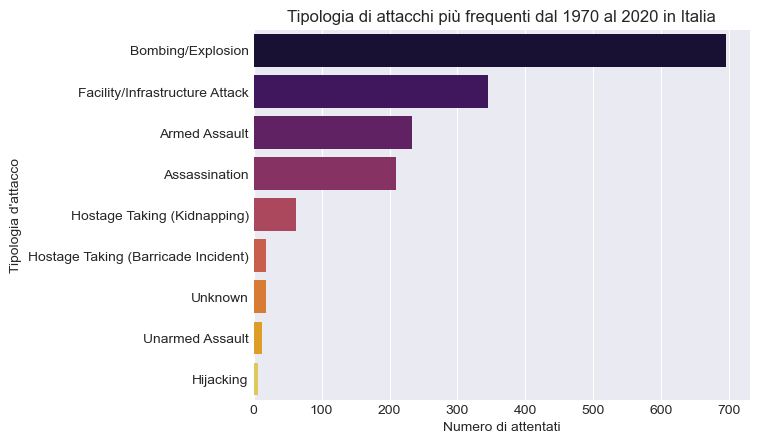

In [46]:
attackTypeFr1 = tr[tr['country_name'] == 'Italy'].groupby("attacktype1_txt").count()['day'].sort_values(ascending=False)
attackTypeFr1 = attackTypeFr1.reset_index().rename(columns={"day":"nAtt"})
ax = sns.barplot(attackTypeFr1, x="nAtt", y="attacktype1_txt", hue="attacktype1_txt", palette="inferno")
ax.set_xlabel("Numero di attentati")
ax.set_ylabel("Tipologia d'attacco")
ax.set_title("Tipologia di attacchi più frequenti dal 1970 al 2020 in Italia")

Text(0.5, 1.0, 'Tipologia delle armi più utilizzate dal 1970 al 2020 in Italia')

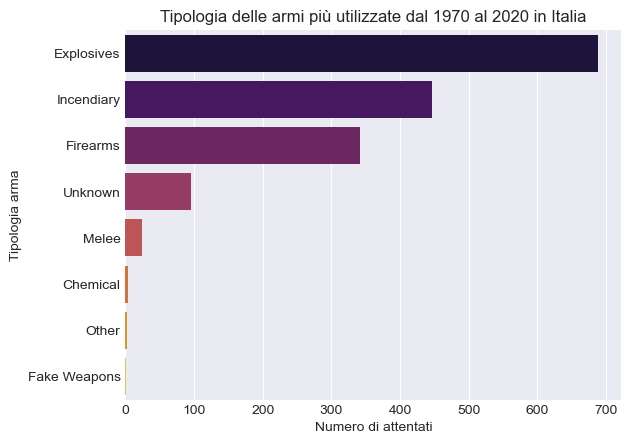

In [47]:
weaponTypeFr1 = tr[tr['country_name'] == 'Italy'].groupby("weaptype1_txt").count()['day'].sort_values(ascending=False)
weaponTypeFr1 = weaponTypeFr1.reset_index().rename(columns={"day":"nAtt"})
ax = sns.barplot(weaponTypeFr1, x="nAtt", y="weaptype1_txt", hue="weaptype1_txt", palette="inferno")
ax.set_xlabel("Numero di attentati")
ax.set_ylabel("Tipologia arma")
ax.set_title("Tipologia delle armi più utilizzate dal 1970 al 2020 in Italia")

<Axes: xlabel='nAtt', ylabel='weaptype1_txt'>

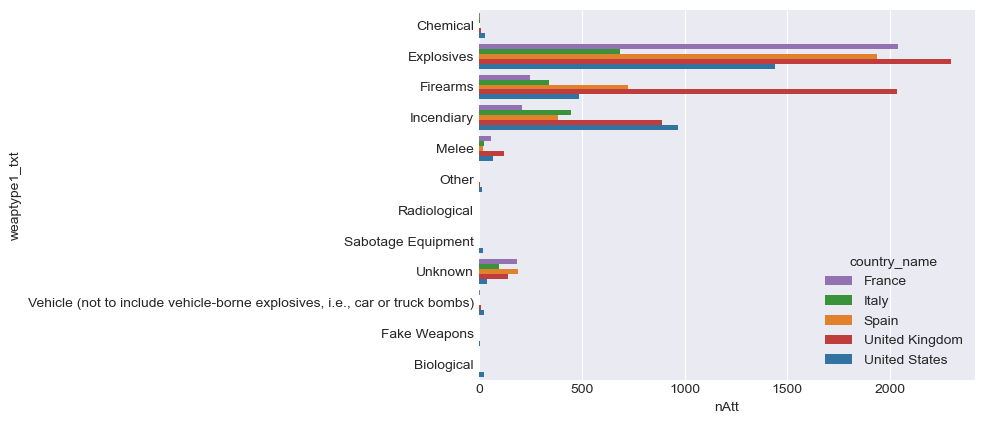

In [48]:
weaponTypeTot = tr.groupby(['country_name','weaptype1_txt']).count()['day'].reset_index().rename(columns={"day":"nAtt"})
sns.barplot(
    weaponTypeTot, 
    x="nAtt", 
    y="weaptype1_txt", 
    hue="country_name",
    palette=countries_color
)

<Axes: xlabel='nAtt', ylabel='targtype1_txt'>

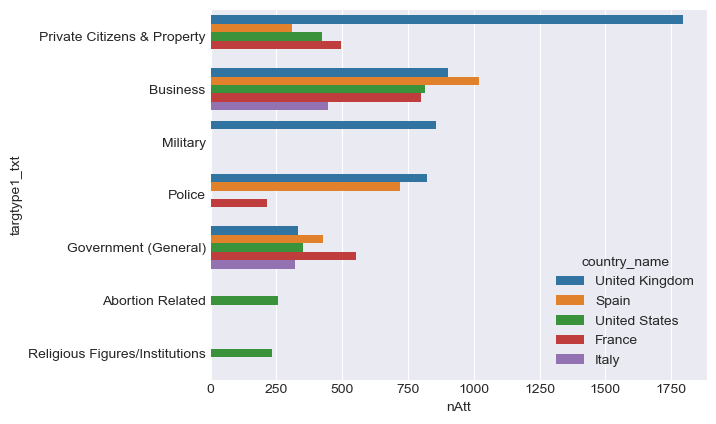

In [49]:
targetTypeTot = tr.groupby(['country_name','targtype1_txt']).count()['day'].reset_index().rename(columns={"day":"nAtt"}).sort_values("nAtt", ascending=False).head(20)
sns.barplot(
    targetTypeTot, 
    x="nAtt", 
    y="targtype1_txt", 
    hue="country_name",
)

In [50]:
len(tr[tr["nkill"] >0]) / len(tr[tr["nkill"] == 0])

0.32352436513383664